<a href="https://colab.research.google.com/github/isaacwanderers/artcreate/blob/main/CLIP_GLaSS_New_function_Full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLIP-GLaSS

Wellcome to the Google's Colab demo of CLIP-GLaSS.

For faster results we encourage you to use your own GPU.


## Instructions

1) Click the play button of the first block titled "CLIP-GLaSS initialization" and wait for it to finish the initialization

2) Select a config and a target from the form titled "CLIP-GLaSS settings"

3) Click the play button of the block titled "CLIP-GLaSS settings"

4) Output Images or Textfile is saved in /content/result/ folder in your files option on the left side bar.

In [1]:
#@title CLIP-GLaSS initialization
import subprocess
import re

nvcc = subprocess.check_output(["nvcc", "--version"]).decode("utf-8")
version = re.findall("release (\d+\.\d+)", nvcc)[0]

pytorch_suffix = {
    "10.0": "+cu100",
    "10.1": "+cu101",
    "10.2": "",
}

pytorch_version = "1.7.1" + (pytorch_suffix[version] if version in pytorch_suffix else "+cu110")
torchvision_version = "0.8.2" + (pytorch_suffix[version] if version in pytorch_suffix else "+cu110")

%cd /content
!mkdir result
!git clone https://github.com/isaacwanderers/artcreate.git
%cd artcreate

try:
  import torch
except:
  !pip install torch=={pytorch_version} -f https://download.pytorch.org/whl/torch_stable.html

try:
  import ipyplot
except:
  !pip install ipyplot

try:
  import torchvision
except:
  !pip install torchvision=={torchvision_version} -f https://download.pytorch.org/whl/torch_stable.html

!pip install pytorch_pretrained_biggan==0.1.1 pymoo==0.4.2.1 kornia==0.4.1 ftfy==5.8 tensorboard==2.4.1

/content
mkdir: cannot create directory ‘result’: File exists
fatal: destination path 'artcreate' already exists and is not an empty directory.
/content/artcreate


In [3]:
#@title CLIP-GLaSS settings
import argparse
import os
import torch
import numpy as np
import pickle
import glob
import random
import array
from PIL import Image
import ipyplot
from pymoo.optimize import minimize
from pymoo.algorithms.so_genetic_algorithm import GA
from pymoo.factory import get_algorithm, get_decision_making, get_decomposition
from pymoo.visualization.scatter import Scatter
import torchvision
from IPython.display import Image, display
import urllib.request


from config import get_config
from problem import GenerationProblem
from operators import get_operators

def display_genre_images(genre):
  image_files = sorted(glob.glob("/content/artcreate/gpt2_images/" + genre +"/*.jpg")) 

  all_images = []
  all_file_names = []

  for i, f in enumerate(image_files):
    #enumerate() returns the index number/order number of the images and the root pathway of the image.
    try:
      image = Image.open(f)
      #open each image as an Image object class, which was imported above from the PIL module.
      all_images.append(image)
      all_file_names.append(f)
    except:
      print("error reading", f)

  file_name = [i.rpartition('/')[2] for i in all_file_names]

  ipyplot.plot_images(all_images, file_name, img_width=150)
  return

development_mode = "create new art from Gund Gallery art" #@param ["interpret Gund Gallery art to text", "create art from text", "create new art from Gund Gallery art"]
genre = "Paintings" #@param ["Drawings", "Mixed Media", "Paintings", "Photography", "Prints", "Sculpture"]
save_each =  100#@param {type:"number"}
generations = 500 #@param {type:"number"}
if development_mode == "interpret Gund Gallery art to text":
  display_genre_images(genre)
  target = "/content/artcreate/gpt2_images" + genre + "/" + input("Input the file name of the image you want to interpret: ") 
  while target.rpartition('.')[2] != "jpg":
    print("File input error: Please include the file extension!")
    target = "/content/artcreate/gpt2_images" + genre + "/" + input("Re-input the file name of the image you want to interpret: ")
  config = "GPT2" 
elif development_mode == "create art from text":
  target = input("Input your target phrase: ") 
  config = "DeepMindBigGAN512"
else:
  display_genre_images(genre)
  target = "/content/artcreate/gpt2_images" + genre + "/" + input("Input the file name of the image you want to develop: ")
  while target.rpartition('.')[2] != "jpg":
    print("File input error: Please include the file extension!")
    target = "/content/artcreate/gpt2_images" + genre + "/" + input("Re-input the file name of the image you want to develop: ")
  element = input("What element stands out the most to you? (1-2 words) ")  
  config = "GPT2"
  ! chmod 755 ./download-weights.sh
  ! ./download-weights.sh GPT2

  config = argparse.Namespace(
      config=config,
      target=target,
      device="cuda",
      generations=generations,
      save_each=save_each,
      tmp_folder="./tmp"
  )

  vars(config).update(get_config(config.config))


  iteration = 0
  def save_callback(algorithm):
      global iteration
      global config

      iteration += 1
      if iteration % config.save_each == 0 or iteration == config.generations:
          if config.problem_args["n_obj"] == 1:
              sortedpop = sorted(algorithm.pop, key=lambda p: p.F)
              X = np.stack([p.X for p in sortedpop])  
          else:
              X = algorithm.pop.get("X")
          
          ls = config.latent(config)
          ls.set_from_population(X)

          with torch.no_grad():
              generated = algorithm.problem.generator.generate(ls, minibatch=config.batch_size)
              name = "genetic-it-%d.jpg" % (iteration) if iteration < config.generations else "genetic-it-final.jpg"

              if config.task == "txt2img":
                  algorithm.problem.generator.save(generated, os.path.join(config.tmp_folder, name))
                  display(Image(os.path.join(config.tmp_folder, name)))
              elif config.task == "img2txt":
                  print("\n".join(generated))
          

  problem = GenerationProblem(config)
  operators = get_operators(config)

  if not os.path.exists(config.tmp_folder): os.mkdir(config.tmp_folder)

  algorithm = get_algorithm(
      config.algorithm,
      pop_size=config.pop_size,
      sampling=operators["sampling"],
      crossover=operators["crossover"],
      mutation=operators["mutation"],
      eliminate_duplicates=True,
      callback=save_callback,
      **(config.algorithm_args[config.algorithm] if "algorithm_args" in config and config.algorithm in config.algorithm_args else dict())
  )

  res = minimize(
      problem,
      algorithm,
      ("n_gen", config.generations),
      save_history=False,
      verbose=True,
  )


  pickle.dump(dict(
      X = res.X,
      F = res.F,
      G = res.G,
      CV = res.CV,
  ), open(os.path.join(config.tmp_folder, "genetic_result"), "wb"))


  if config.problem_args["n_obj"] == 1:
      X = np.atleast_2d(res.X)
  else:
      try:
          result = get_decision_making("pseudo-weights", [0, 1]).do(res.F)
      except:
          print("Warning: cant use pseudo-weights")
          result = get_decomposition("asf").do(res.F, [0, 1]).argmin()
      X = res.X[result]
      X = np.atleast_2d(X)


  ls = config.latent(config)
  ls.set_from_population(X)

  with torch.no_grad():
      generated = problem.generator.generate(ls)

  problem.generator.save(generated, ("/content/result/output.txt"))
  text_file = open("/content/result/output.txt", "r")
  target = text_file.read()
  text_file.close()
  config = "DeepMindBigGAN512"



if config != "GPT2":
  target = genre.lower() + " with " + target

if config == "GPT2":
  try:
    ! ./download-weights.sh GPT2
  except:
    ! chmod 755 ./download-weights.sh
    ! ./download-weights.sh GPT2

config = argparse.Namespace(
    config=config,
    target=target,
    device="cuda",
    generations=generations,
    save_each=save_each,
    tmp_folder="./tmp"
)

vars(config).update(get_config(config.config))


iteration = 0
def save_callback(algorithm):
    global iteration
    global config

    iteration += 1
    if iteration % config.save_each == 0 or iteration == config.generations:
        if config.problem_args["n_obj"] == 1:
            sortedpop = sorted(algorithm.pop, key=lambda p: p.F)
            X = np.stack([p.X for p in sortedpop])  
        else:
            X = algorithm.pop.get("X")
        
        ls = config.latent(config)
        ls.set_from_population(X)

        with torch.no_grad():
            generated = algorithm.problem.generator.generate(ls, minibatch=config.batch_size)
            name = "genetic-it-%d.jpg" % (iteration) if iteration < config.generations else "genetic-it-final.jpg"

            if config.task == "txt2img":
                algorithm.problem.generator.save(generated, os.path.join(config.tmp_folder, name))
                display(Image(os.path.join(config.tmp_folder, name)))
            elif config.task == "img2txt":
                print("\n".join(generated))
        

problem = GenerationProblem(config)
operators = get_operators(config)

if not os.path.exists(config.tmp_folder): os.mkdir(config.tmp_folder)

algorithm = get_algorithm(
    config.algorithm,
    pop_size=config.pop_size,
    sampling=operators["sampling"],
    crossover=operators["crossover"],
    mutation=operators["mutation"],
    eliminate_duplicates=True,
    callback=save_callback,
    **(config.algorithm_args[config.algorithm] if "algorithm_args" in config and config.algorithm in config.algorithm_args else dict())
)

res = minimize(
    problem,
    algorithm,
    ("n_gen", config.generations),
    save_history=False,
    verbose=True,
)


pickle.dump(dict(
    X = res.X,
    F = res.F,
    G = res.G,
    CV = res.CV,
), open(os.path.join(config.tmp_folder, "genetic_result"), "wb"))


if config.problem_args["n_obj"] == 1:
    X = np.atleast_2d(res.X)
else:
    try:
        result = get_decision_making("pseudo-weights", [0, 1]).do(res.F)
    except:
        print("Warning: cant use pseudo-weights")
        result = get_decomposition("asf").do(res.F, [0, 1]).argmin()
    X = res.X[result]
    X = np.atleast_2d(X)

print("="*50)
print("RESULT")
print("="*50)


ls = config.latent(config)
ls.set_from_population(X)

with torch.no_grad():
    generated = problem.generator.generate(ls)


if config.task == "txt2img":
    problem.generator.save(generated, ("/content/result/output.jpg"))
    display(Image("/content/result/output.jpg"))
elif config.task == "img2txt":
    print(generated)
    problem.generator.save(generated, ("/content/result/output.txt"))


KeyboardInterrupt: ignored

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
100%|██████████| 800/800 [00:00<00:00, 171257.24B/s]


n_gen |  n_eval |   cv (min)   |   cv (avg)   |     fopt     |     favg    
    1 |      32 |  0.00000E+00 |  0.00000E+00 |      -0.2515 |       -0.201
    2 |      64 |  0.00000E+00 |  0.00000E+00 |      -0.2664 |      -0.2244
    3 |      96 |  0.00000E+00 |  0.00000E+00 |      -0.2664 |      -0.2362
    4 |     128 |  0.00000E+00 |  0.00000E+00 |      -0.2698 |      -0.2417
    5 |     160 |  0.00000E+00 |  0.00000E+00 |      -0.2803 |      -0.2471
    6 |     192 |  0.00000E+00 |  0.00000E+00 |      -0.2803 |      -0.2502
    7 |     224 |  0.00000E+00 |  0.00000E+00 |      -0.2803 |       -0.252
    8 |     256 |  0.00000E+00 |  0.00000E+00 |      -0.2812 |      -0.2546
    9 |     288 |  0.00000E+00 |  0.00000E+00 |      -0.2812 |      -0.2554
   10 |     320 |  0.00000E+00 |  0.00000E+00 |      -0.2812 |      -0.2563
   11 |     352 |  0.00000E+00 |  0.00000E+00 |      -0.2812 |      -0.2585
   12 |     384 |  0.00000E+00 |  0.00000E+00 |      -0.2937 |      -0.2617
   13 |     

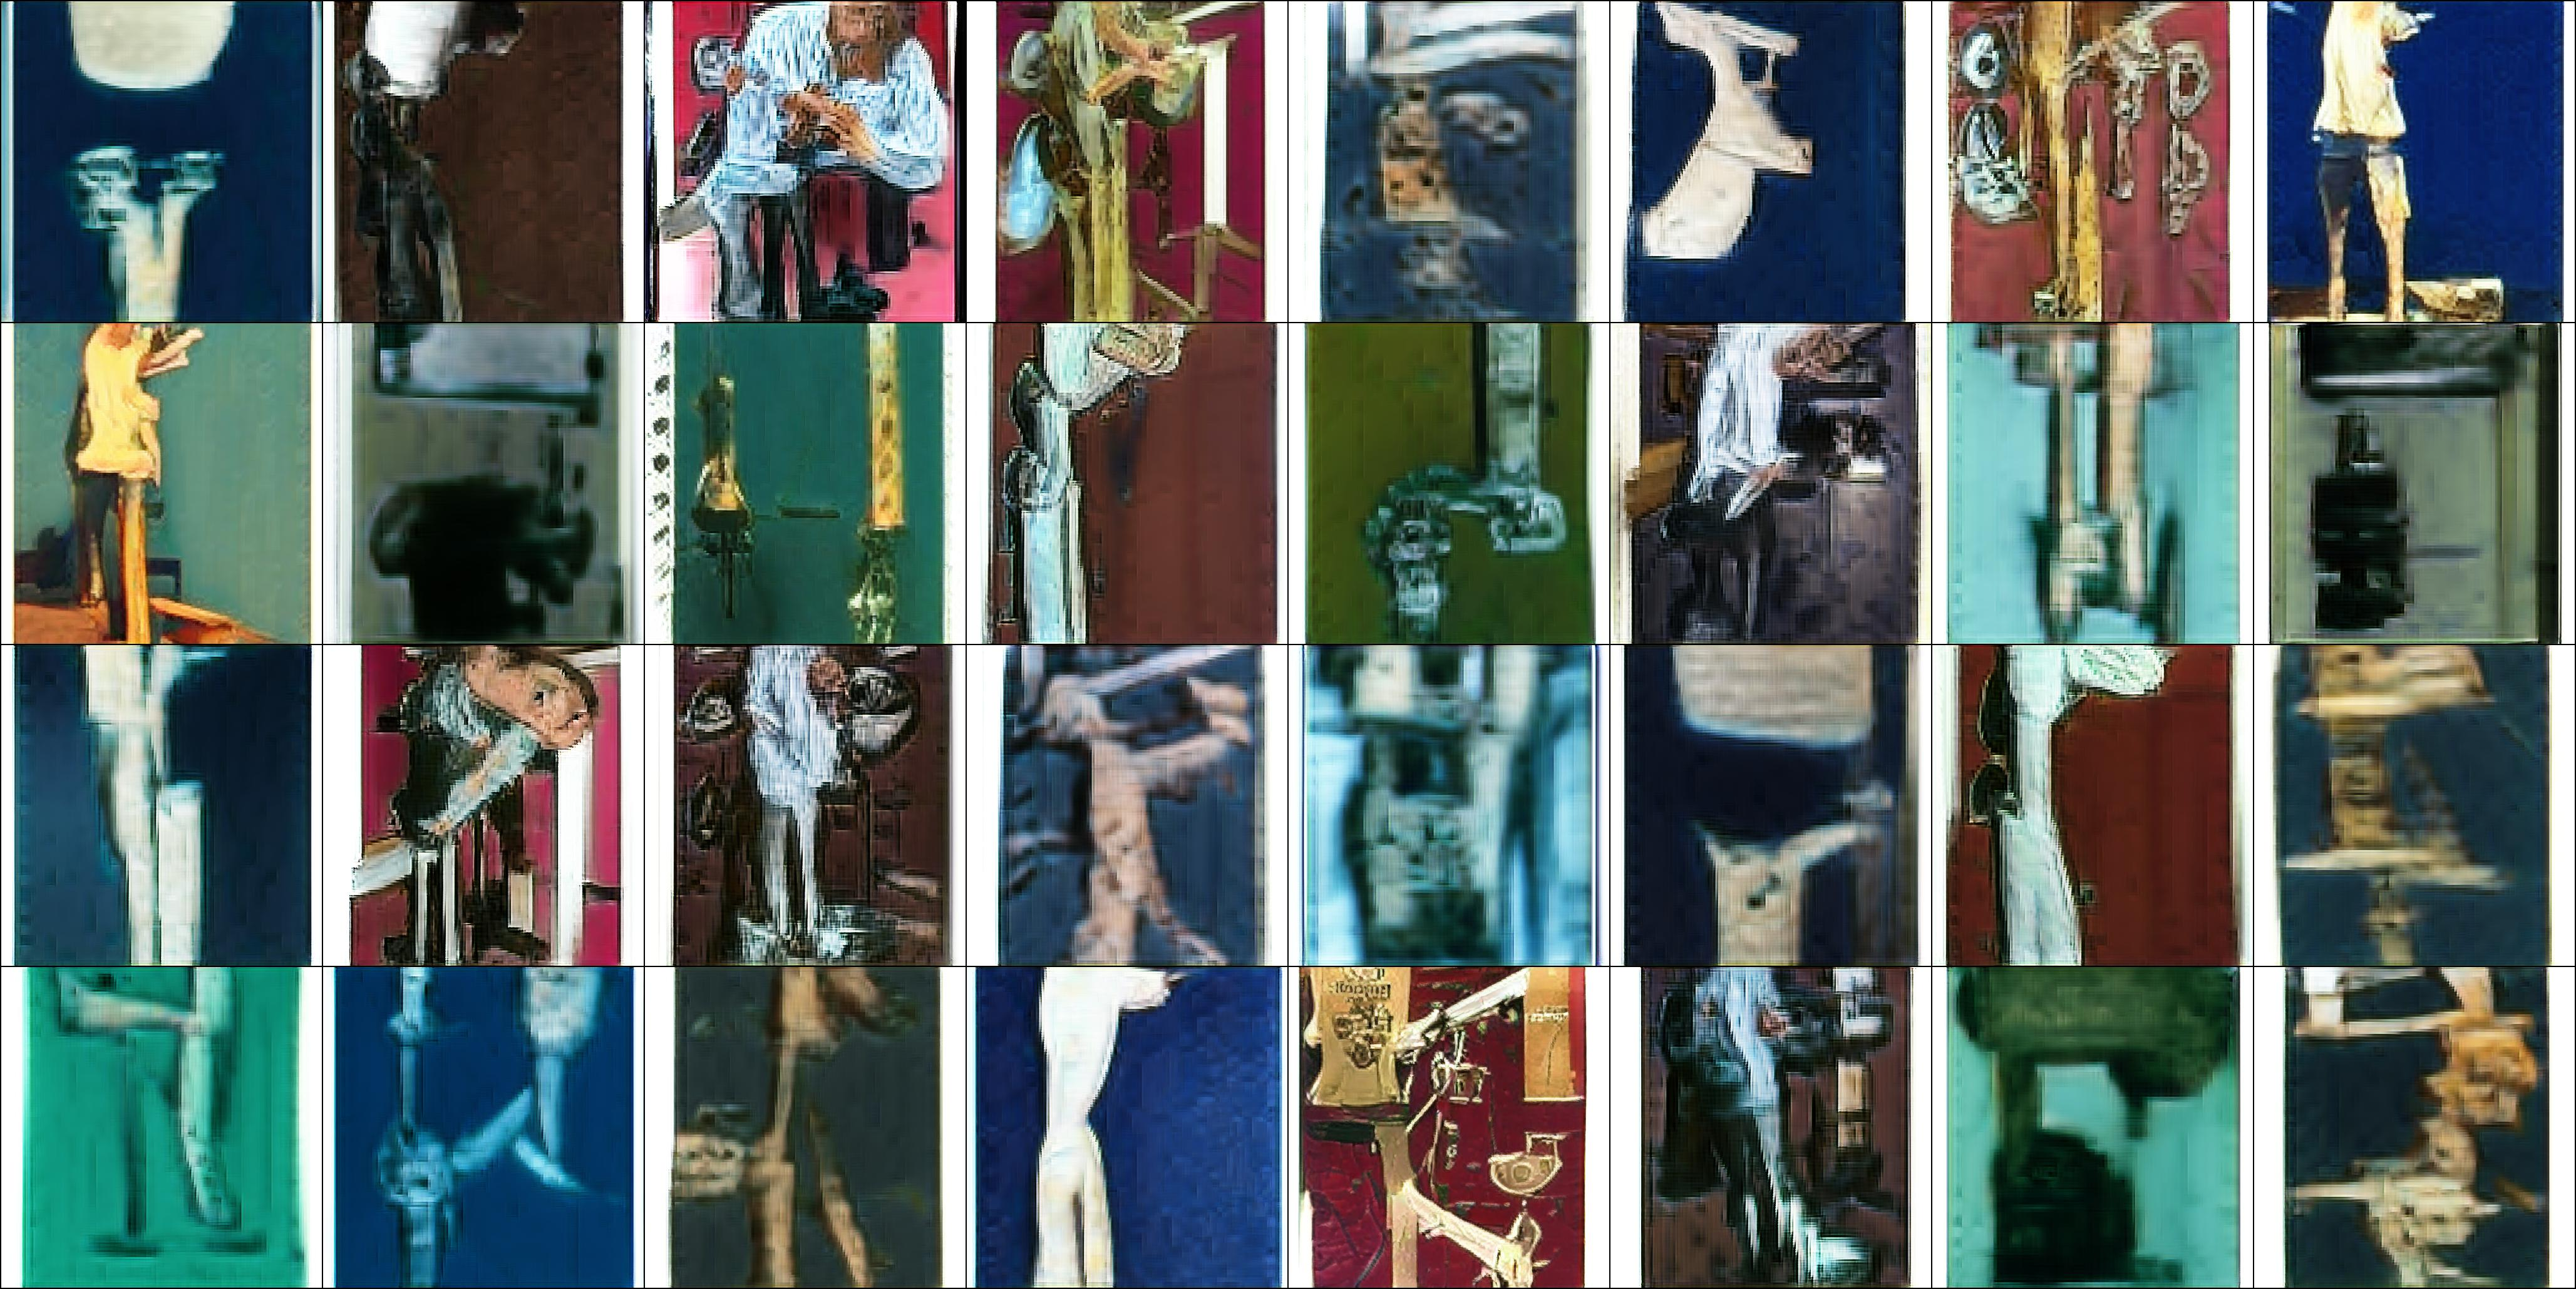

  101 |    3232 |  0.00000E+00 |  0.00000E+00 |      -0.3147 |       -0.301
  102 |    3264 |  0.00000E+00 |  0.00000E+00 |      -0.3147 |      -0.3018
  103 |    3296 |  0.00000E+00 |  0.00000E+00 |      -0.3147 |      -0.3018
  104 |    3328 |  0.00000E+00 |  0.00000E+00 |      -0.3147 |      -0.3018
  105 |    3360 |  0.00000E+00 |  0.00000E+00 |      -0.3147 |       -0.302
  106 |    3392 |  0.00000E+00 |  0.00000E+00 |      -0.3147 |      -0.3027
  107 |    3424 |  0.00000E+00 |  0.00000E+00 |      -0.3147 |      -0.3027
  108 |    3456 |  0.00000E+00 |  0.00000E+00 |      -0.3147 |      -0.3027
  109 |    3488 |  0.00000E+00 |  0.00000E+00 |      -0.3147 |      -0.3027
  110 |    3520 |  0.00000E+00 |  0.00000E+00 |      -0.3147 |       -0.303
  111 |    3552 |  0.00000E+00 |  0.00000E+00 |      -0.3147 |       -0.303
  112 |    3584 |  0.00000E+00 |  0.00000E+00 |      -0.3147 |       -0.303
  113 |    3616 |  0.00000E+00 |  0.00000E+00 |      -0.3147 |       -0.303
  114 |    3

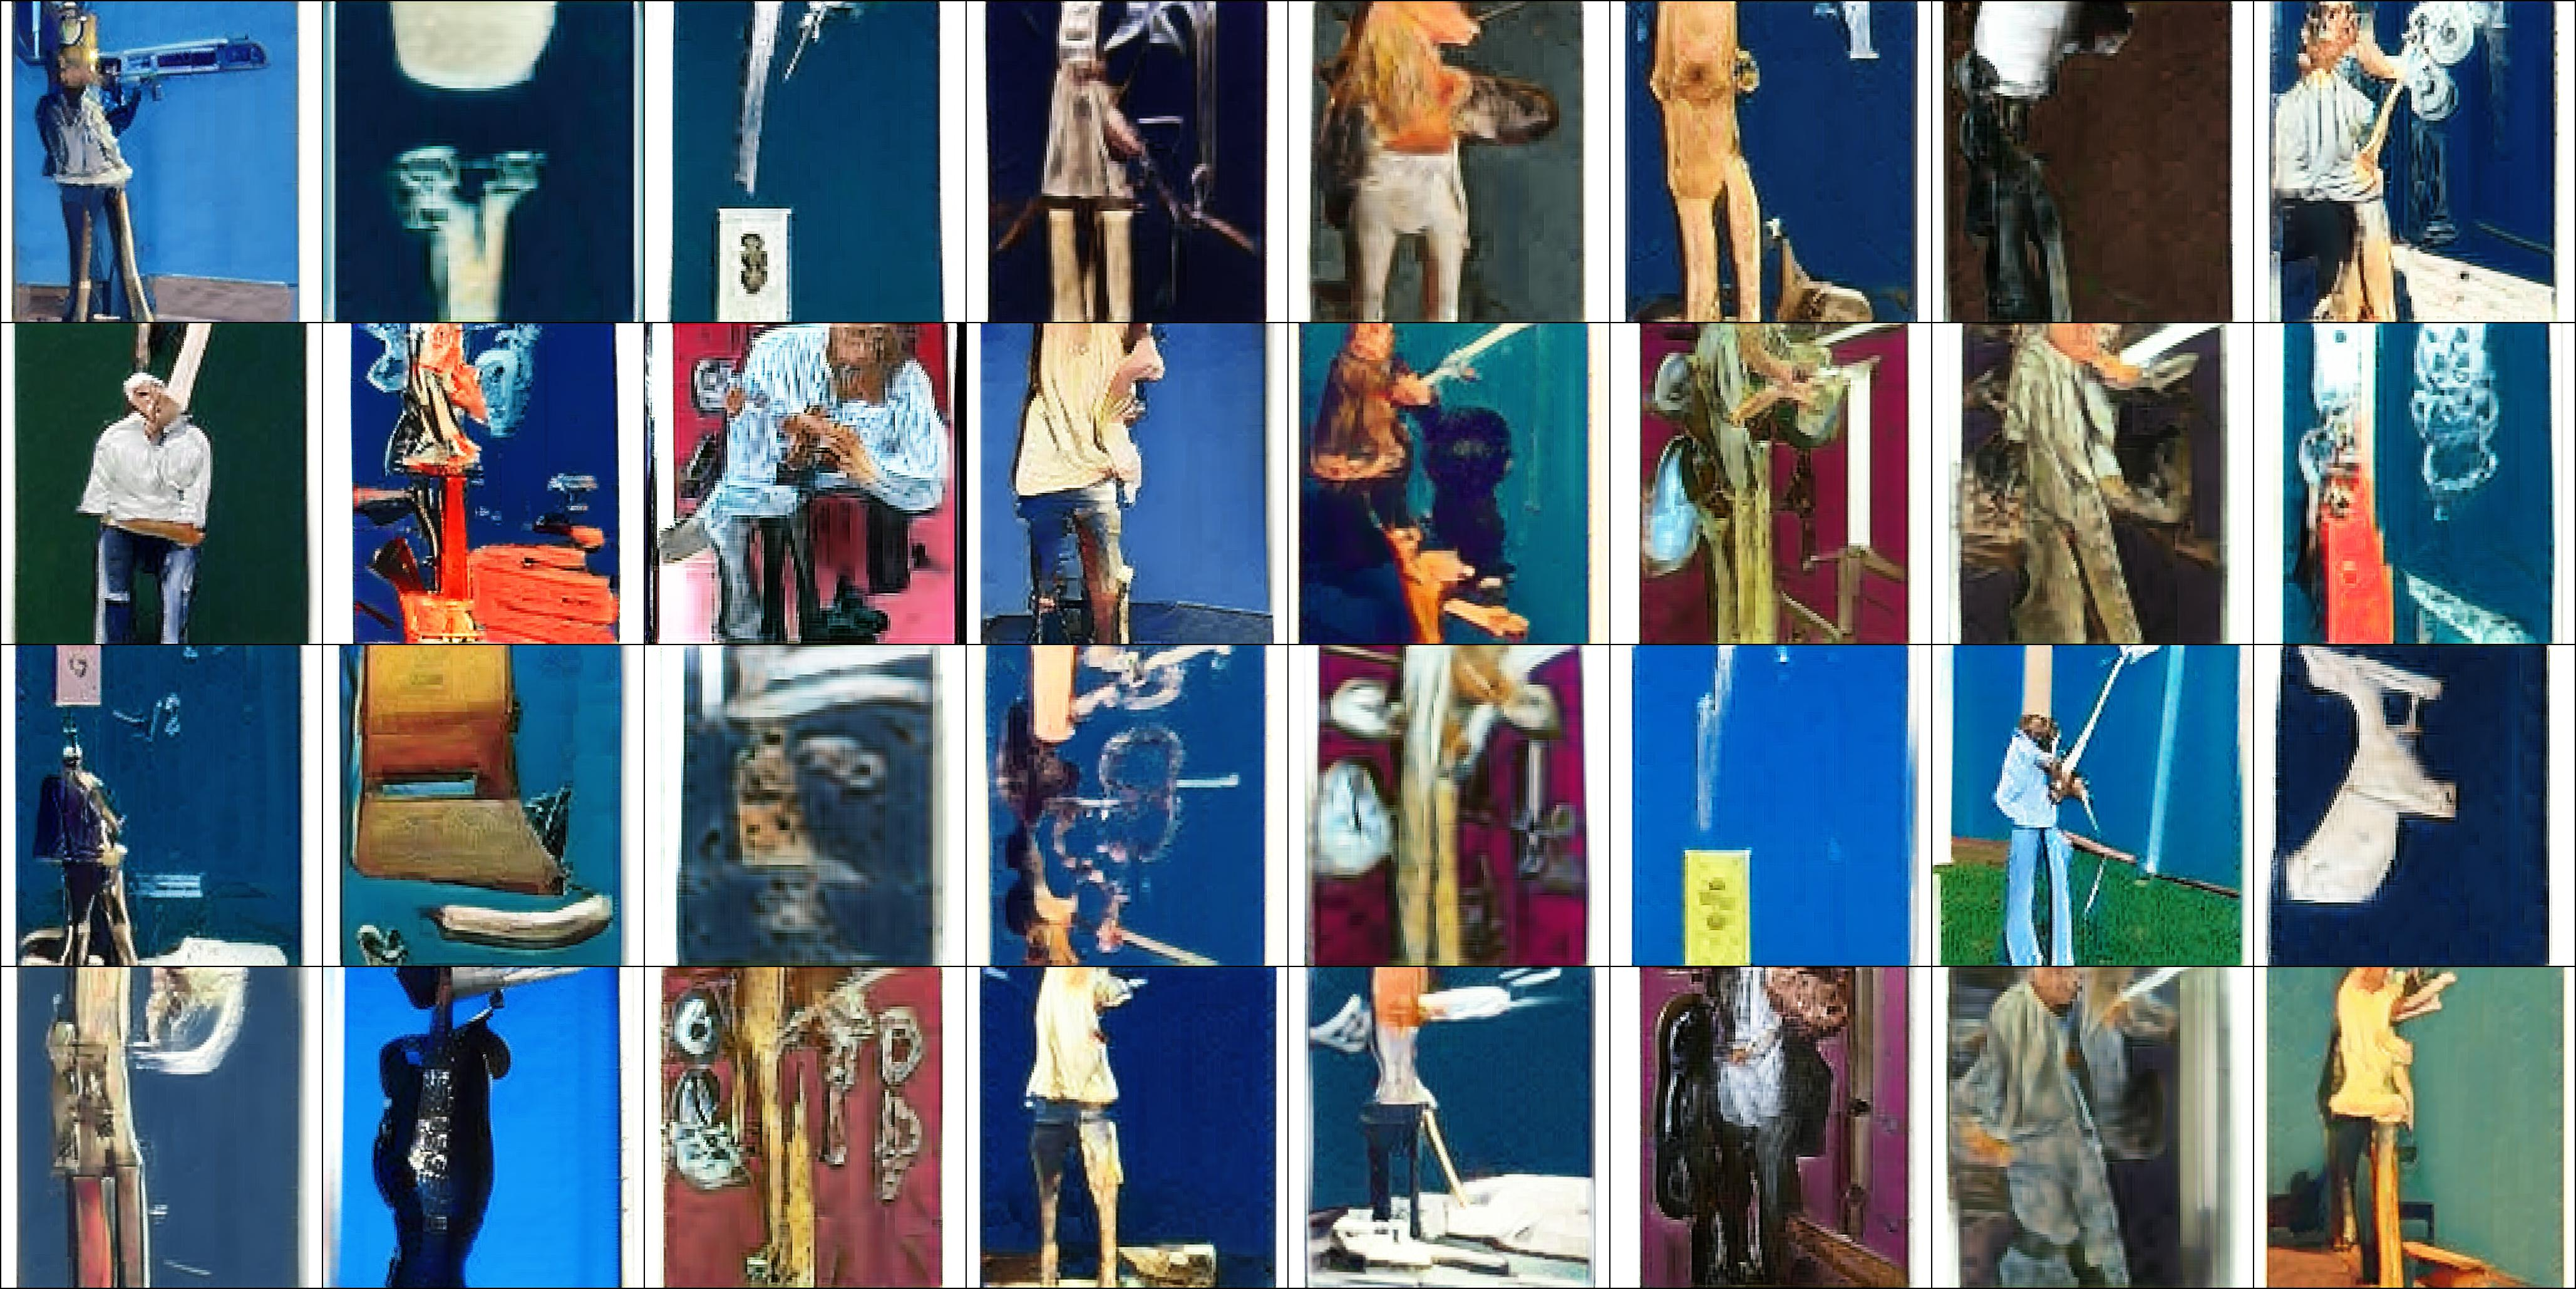

  201 |    6432 |  0.00000E+00 |  0.00000E+00 |      -0.3184 |      -0.3076
  202 |    6464 |  0.00000E+00 |  0.00000E+00 |      -0.3184 |      -0.3076
  203 |    6496 |  0.00000E+00 |  0.00000E+00 |      -0.3184 |      -0.3076
  204 |    6528 |  0.00000E+00 |  0.00000E+00 |      -0.3184 |      -0.3076
  205 |    6560 |  0.00000E+00 |  0.00000E+00 |      -0.3184 |      -0.3076
  206 |    6592 |  0.00000E+00 |  0.00000E+00 |      -0.3184 |      -0.3076
  207 |    6624 |  0.00000E+00 |  0.00000E+00 |      -0.3184 |      -0.3076
  208 |    6656 |  0.00000E+00 |  0.00000E+00 |      -0.3184 |      -0.3076
  209 |    6688 |  0.00000E+00 |  0.00000E+00 |      -0.3184 |      -0.3076
  210 |    6720 |  0.00000E+00 |  0.00000E+00 |      -0.3184 |      -0.3076
  211 |    6752 |  0.00000E+00 |  0.00000E+00 |      -0.3184 |      -0.3076
  212 |    6784 |  0.00000E+00 |  0.00000E+00 |      -0.3184 |      -0.3076
  213 |    6816 |  0.00000E+00 |  0.00000E+00 |      -0.3184 |      -0.3076
  214 |    6

In [ ]:
text_file = open("/content/result/output.txt", "r")
target = text_file.read()
text_file.close()
config = "DeepMindBigGAN512"



if config != "GPT2":
  target = genre.lower() + " with " + target

if config == "GPT2":
  ! chmod 755 ./download-weights.sh
  ! ./download-weights.sh GPT2

config = argparse.Namespace(
    config=config,
    target=target,
    device="cuda",
    generations=generations,
    save_each=save_each,
    tmp_folder="./tmp"
)

vars(config).update(get_config(config.config))


iteration = 0
def save_callback(algorithm):
    global iteration
    global config

    iteration += 1
    if iteration % config.save_each == 0 or iteration == config.generations:
        if config.problem_args["n_obj"] == 1:
            sortedpop = sorted(algorithm.pop, key=lambda p: p.F)
            X = np.stack([p.X for p in sortedpop])  
        else:
            X = algorithm.pop.get("X")
        
        ls = config.latent(config)
        ls.set_from_population(X)

        with torch.no_grad():
            generated = algorithm.problem.generator.generate(ls, minibatch=config.batch_size)
            name = "genetic-it-%d.jpg" % (iteration) if iteration < config.generations else "genetic-it-final.jpg"

            if config.task == "txt2img":
                algorithm.problem.generator.save(generated, os.path.join(config.tmp_folder, name))
                display(Image(os.path.join(config.tmp_folder, name)))
            elif config.task == "img2txt":
                print("\n".join(generated))

problem = GenerationProblem(config)
operators = get_operators(config)

if not os.path.exists(config.tmp_folder): os.mkdir(config.tmp_folder)

algorithm = get_algorithm(
    config.algorithm,
    pop_size=config.pop_size,
    sampling=operators["sampling"],
    crossover=operators["crossover"],
    mutation=operators["mutation"],
    eliminate_duplicates=True,
    callback=save_callback,
    **(config.algorithm_args[config.algorithm] if "algorithm_args" in config and config.algorithm in config.algorithm_args else dict())
)

res = minimize(
    problem,
    algorithm,
    ("n_gen", config.generations),
    save_history=False,
    verbose=True,
)


pickle.dump(dict(
    X = res.X,
    F = res.F,
    G = res.G,
    CV = res.CV,
), open(os.path.join(config.tmp_folder, "genetic_result"), "wb"))


if config.problem_args["n_obj"] == 1:
    X = np.atleast_2d(res.X)
else:
    try:
        result = get_decision_making("pseudo-weights", [0, 1]).do(res.F)
    except:
        print("Warning: cant use pseudo-weights")
        result = get_decomposition("asf").do(res.F, [0, 1]).argmin()
    X = res.X[result]
    X = np.atleast_2d(X)

print("="*50)
print("RESULT")
print("="*50)


ls = config.latent(config)
ls.set_from_population(X)

with torch.no_grad():
    generated = problem.generator.generate(ls)


if config.task == "txt2img":
    problem.generator.save(generated, ("/content/result/output.jpg"))
    display(Image("/content/result/output.jpg"))
elif config.task == "img2txt":
    print(generated)
    problem.generator.save(generated, ("/content/result/output.txt"))
